# Image vector quantization is just like creating a tilemap

Pekka Väänänen | [30fps.net](https://30fps.net/) |
*April 30th, 2023*

Did you know that *Cannon Fodder* on the Game Boy Color had a full motion video intro? See below *but turn down the volume*:

<iframe width="560" height="315" src="https://www.youtube.com/embed/dy0y6Vo94Bc" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

It's pretty obvious how it has to work because the Game Boy has no bitmap display mode. They split each frame into 8×8 pixel tiles and express each frame as a tilemap. When the next frame comes in you only update the tiles that changed and there you go: a video codec has been born.

But wait a minute. The decoding part is simple, a children's toy can do it in hardware, but how do you convert each frame into a tilemap?

## It's vector quantization

Splitting each frame into Game Boy video hardware tiles is an example of lossy image compression with the *vector quantization* (VQ) algorithm. It has been used [in many video codecs](https://en.wikipedia.org/wiki/Vector_quantization#Video_codecs_based_on_vector_quantization) and for example in the classic [Command & Conquer games](https://www.youtube.com/watch?v=Qtb4uow940c). It's just so fast to decode.

### How it works

This notebook shows how to compress a single image to a tilemap and its tileset (its *codebook*).

We will

1. split an image into 8×8 pixel blocks (or "tiles"),
2. reorganize those blocks into a big list of 1D vectors,
3. cluster those using [the K-means algorithm](https://en.wikipedia.org/wiki/Vector_quantization#Video_codecs_based_on_vector_quantization), and
3. then assign each image block to a cluster.

This is lossy image compression because we can then transmit the image as a set clusters and block-to-cluster assignments in smaller size. Note that we are *not* quantizing the colors to a palette, even though VQ is often used for that purpose.

## Load and crop an image

Let's use a *Super Mario Bros. 3* menu screenshot as an example to make the connection to tilemaps obvious.

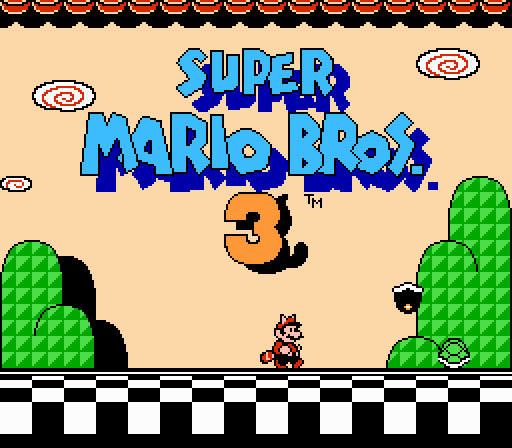

In [1]:
from PIL import Image
import numpy as np
from IPython.display import display

def imshow(array):
    display(Image.fromarray(array.astype(np.uint8)))

def zoom(image, factor=4):
    return np.kron(image, np.ones((factor, factor, 1)))

input_image = Image.open("smb3titlescreen.png")
im = np.asarray(input_image)
imshow(zoom(im,2))

I paused the game in an emulator and copied below the NES "pattern tables", or tilesets if you will:

![PPU pattern tables](ppu_pattern_tables.png)

On the left you have the static tiles and on the right the sprites. 
The colors look off because the palette is wrong.
Anyway, we are going to create something like these automatically but of course the sprites and tiles will be all mixed together.

Next, compute the image size in $B=8$ sized blocks and crop.

In [2]:
# Block size in pixels
B = 8

# Image size in pixels
h, w, _ = im.shape

# Image size measured in blocks instead of pixels
bh, bw = h//B, w//B

# Round image size to a multiple of block size
h = bh * B
w = bw * B

# Crop the image
im = im[:h,:w]

print(f"Image size in pixels: {w} x {h}")
print(f"Image size in blocks: {bw} x {bh}")

Image size in pixels: 256 x 224
Image size in blocks: 32 x 28


## Split the image into blocks and convert to a big data array $X$

We wish to convert the image into an `[N x D]` array $X$ of $N$ rows with $D$-dimensional row vectors. This is a common input format for machine learning algorithms and also [scikit-learn's **KMeans** class](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) can understand it. Each block will become a row in the array.

Our input image is an RGB bitmap of shape `[h x w x 3]` and we convert it to an array of vectors with some **np.array** trickery:

1. Add an extra dimension of size 8 after the y and x axes.
2. Reorder the dimensions to `[56 x 64 x 8 x 8 x 3]`.
3. Reshape into an `[N x 192]` array of row vectors.

This technique is admittedly pretty confusing but it (a) avoids making a copy of the data and (b) doesn't need for loops :)
I wish I could explain it better.
We can't go for the third step's reshape call directly because then we'd split the image into 64 x 1 pixel slices instead.


Data matrix 'X' shape [N x D]: (896, 192)
Example blocks


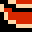

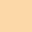

One 192-dimensional data vector:


In [3]:
# im shape is                                 [h x w x 3]
blocks = im.reshape(bh, B, bw, B, 3)        # [bh x B x bw x B x 3]
blocks = blocks.transpose(0, 2, 1, 3, 4)    # [bh x bw x B x B x 3]

# Length of each data vector: 8*8*3 = 192 components
D = B * B * 3

# Create the data array
X = blocks.reshape(-1, D) # [N x 192]

print(f"Data matrix 'X' shape [N x D]: {X.shape}")

print("Example blocks")
imshow(zoom(blocks[0,0]))
imshow(zoom(blocks[10,0]))

print(f"One {D}-dimensional data vector:")
imshow(zoom(X[0].reshape(1,192,1))[...,0])

As you can see, in the array $X$ the RGB pixel data of each block has been flattened to a single dimension.

## Find the codebook and block assignments

Now that we have our data in the array $X$ we can treat the 8×8 blocks as general 192-dimensional vectors.
This is great because the **KMeans** class can operate on them directly, making our life very easy.

By calling `KMeans.fit(X)` and `kmeans.predict(X)` we produce two arrays:

- **codebook**: the tileset represented as a `[num_codes x D]` array of row vectors, and
- **codes**: an index to the codebook for each block in the image, basically a `[bh x bw]` tilemap.


In [4]:
from sklearn.cluster import KMeans

# Quantize the input vectors into 'num_codes' representatives.
# In other words, divide the 192-dimensional vectors into 'num_codes' clusters.

num_codes = 180
kmeans = KMeans(n_clusters=num_codes, random_state=0, n_init='auto').fit(X)

# The found cluster centers will be our "codebook".
# This is the "tileset".
codebook = kmeans.cluster_centers_

# Assign each image block the closest codeword from the codebook.
# This is the "tilemap".
codes = kmeans.predict(X)

The "quantization" part of "vector quantization" happens here in `kmeans.predict(X)` when each block is assigned an index in the codebook; the blocks are represented as an integer index instead of the original pixel data.

The codebook:


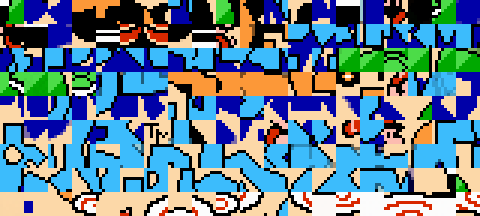

Color coded per block code assignments:


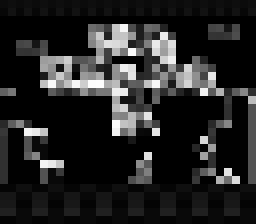

In [5]:
# An inverse operation of the np.array trickery from earlier.
# Converts an [N x D] array back to [h x w x 3] image
def vectors_to_pixels(x, h, w):
    #                                 [N, D]            input shape
    x = x.reshape(h, w, -1)         # [bh, bw, D]       a 2D array of vectors
    x = x.reshape(h, w, B, B, 3)    # [bh, bw, 8, 8, 3] a 2D array of RGB blocks
    x = x.transpose(0, 2, 1, 3, 4)  # [bh, 8, bw, 8, 3] reorder block axes
    x = x.reshape(h*B, w*B, 3)      # [h, w, 3]         collapse back to pixels
    return x

# Show the codebook ordered by brightness
print("The codebook:")
briteness_order = np.argsort(np.median(codebook, axis=1))
codebook_im = vectors_to_pixels(codebook[briteness_order], num_codes//20, 20)
imshow(zoom(codebook_im,3))

print("Color coded per block code assignments:")
c_im = (codes.reshape(bh, bw, 1) / num_codes) * 255
imshow(zoom(c_im, B)[...,0])

## Decode the compressed image

Decoding is done in two steps:
1. first look up the codeword for each block, and
2. then reorder the codewords back to RGB pixels.

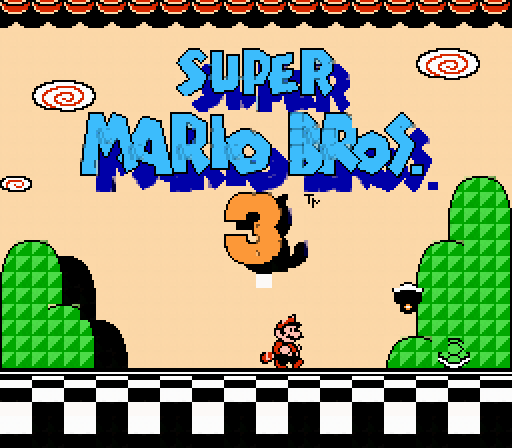

In [6]:
# Here 'decoded' is the same shape as 'X' but degraded due to lossy compression.
decoded = codebook[codes]

# Convert the big list of codes back to pixels.
result = vectors_to_pixels(decoded, bh, bw)

imshow(zoom(result, 2))

In [7]:
# Print codebook data compression ratio.
# It's a bit too optimistic because it's missing the size of the 'codes' array.
print(f"Compression ratio would be {X.shape[0]/num_codes:.3}:1")

Compression ratio would be 4.98:1


## Making it better

There are many ways to improve this algorithm:

- Use some other colorspace instead of RGB. The usual YCbCr worked OK in my tests.
- Use a smarter clustering method:
    - For large images [Mini-Batch K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) with random initialization seems to run much faster.
    - The [Generalized Lloyd's Algorithm (GLA)](https://en.wikipedia.org/wiki/Lloyd%27s_algorithm) is very close to K-Means but the centroids are computed from voronoi regions bounds, not as a mean of vectors assigned to that cluster.
- Pack the codebook tighter for example with a 16-bit pixel format.
- Add delta coding, some compression like [Zstandard](https://github.com/facebook/zstd), and conquer the world with your fancy new codec! :)

You can download [the notebook](vq-compression.ipynb) and the [test image](smb3titlescreen.png).

*Thanks to Lauri Saikkonen, noby and mankeli for helpful comments on a draft of this notebook.*

## requirements.txt

```
ipython==8.13.0
numpy==1.24.3
Pillow==9.5.0
scikit_learn==1.2.2
```

Python 3.9.9

## License (MIT)

Copyright (c) 2023 Pekka Väänänen

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.